## 1. The Project
### 1.1 Project Description
The aim of this project is to build an RNN model that classifies Tweets into real disasters and non-disasters. 

### 1.2 Project Background
With the growing adoption by users around the globe, social media and especially Twitter has become an important communication channel in times of emergency.

The ubiquitousness and convenience of portable devices such as smartphones and tablets, enable users to report an emergency they are observing in real-time. As a result, many agencies, including governments, disaster relief NGOs, as well as media outlets have become increasingly interested in monitoring Twitter posts (or tweets) to discover breaking events from ground zero.

However, due to the huge volume of tweets posted (estimated to be over 350,000 tweets per minute), it is impossible to classify these tweets manually. Therefore, agencies have turned to machine learning models to help them automatically monitor and filter out tweets that are about real disasters. These much smaller subset of tweets can then be analyzed by humans as a basis for further actions.

### 1.3 Project Evaluation
The model results will be evaluated using the F1 score. The F1 score is the harmonic mean of precision and recall and it is calculated as:

$$F1 = 2 * \frac{precision\, * \,recall}{precision\, + \,recall}$$

Where

$$precision = \frac{True \, Positives}{True\, Positives \, + \, False \,Positives}$$

$$recall = \frac{True \,Positives}{True\, Positives \, + \, False \,Negatives}$$

-------------------

## 2. The Data
### 2.1 Data Description
The dataset for this project contains almost 10,000 tweets that were hand classified into disasters and non-disasters. The training set contains 7613 observations, and the test set contains 3243 observations.

The data set contains the following features:
> 1. id - a unique identifier for each tweet
> 2. text - the text of the tweet
> 3. location - the location the tweet was sent from (may be blank)
> 4. keyword - a particular keyword from the tweet (may be blank)
> 5. target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)


### 2.2 Data Source
This dataset can be found on [Kaggle](https://www.kaggle.com/competitions/nlp-getting-started/data).

--------------

## 3. Loading the Libraries and Data
### 3.1 Loading the Libraries

In [2]:
import os

# 1. Importing the necessary packages
# 1.1 Data Manipulation and Computations
import pandas as pd
import numpy as np
from collections import defaultdict

# 1.2 Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud


# NLP
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
from keras_preprocessing.text import text_to_word_sequence
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

#nltk.download('averaged_perceptron_tagger')
#nltk.download('omw-1.4')
#from nltk.corpus import wordnet




# Settings
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [88]:
# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline


# Deep Learning
import tensorflow as tf
import keras # high-level deep learning API
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import (Embedding,LSTM,
                          Dense,
                          SpatialDropout1D,
                          Bidirectional,
                          BatchNormalization,
                          TimeDistributed, 
                          Dropout, 
                          Flatten, 
                          GlobalMaxPool1D)
from keras.initializers import Constant
from keras.optimizers import adam_v2
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import keras.backend as K


from keras.layers import (LSTM, 
                          Embedding, 
                          )

### 3.2 Loading the Data

In [4]:
# Importing the data from Google Drive
tweet = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
tweet.head() # We can already see that there are many missing values in "keyword" and "location" column.

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Looks like the train and test sets may come from the same sample (as indicated by the id - what's missing in train is found in test)

In [5]:
test.head(3) 

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."


As we can see, we have 7552 "keyword" observations, and 221 of them are unique. While out of the 5080 "location", more than 3300 of them are unique. This represents high cardinality in the "location" column. On closer inspection of the source data description, we note that the "location" here are user-entered, and they are rather noisy. **It will be benefitical to in fact not include "location" in our analysis.**

We can also see that we have some duplicate Twitter "text", where multiple tweets share the same underlying message. This may be due to retweets or copy and pasting by the user. **It would be worthwhile to examine these duplicates and check whether the target has been labelled consistently.**

In [6]:
tweet.describe(include = 'all')

,id,keyword,location,text,target
count,7613.000000,7552,5080,7613,7613.00000
unique,NaN,221,3341,7503,NaN
top,NaN,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...,NaN
freq,NaN,45,104,10,NaN
mean,5441.934848,NaN,NaN,NaN,0.42966
std,3137.116090,NaN,NaN,NaN,0.49506
min,1.000000,NaN,NaN,NaN,0.00000
25%,2734.000000,NaN,NaN,NaN,0.00000
50%,5408.000000,NaN,NaN,NaN,0.00000
75%,8146.000000,NaN,NaN,NaN,1.00000


We can see that target = 0 (Not a disaster tweet) has 15% more observations than the positive class (target = 1, a disaster tweet). Which means the dataset is fairly balanced.

In [7]:
tweet.target.value_counts(normalize = True)

0    0.57034
1    0.42966
Name: target, dtype: float64

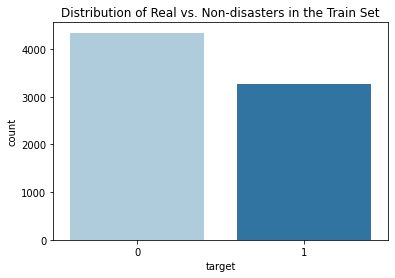

In [9]:
sns.countplot(x = tweet.target, palette = 'Paired')
plt.title("Distribution of Real vs. Non-disasters in the Train Set"); 

-----------

## 4. Exploratory Data Analysis (EDA)
EDA serves two main purposes:
1. Verifying data quality: guides us in data cleaning and preparation
  - Missing values
  - Duplicate entries
  - Inconsistent entries and labels
  - Outliers
  - Rare categorical classes
  - etc...
2. Exploring data characteristics: guides us in feature engineering
  - Patterns unique/interesting in the data
  - Feature characteristics and distribution
  - etc...

### 4.1 Data Quality Exploration
#### 4.1.1 Missing Values
We can see that the location values seem to be missing at random (and there are lots of them missing - more than 30%). We should drop the location column from our analysis.

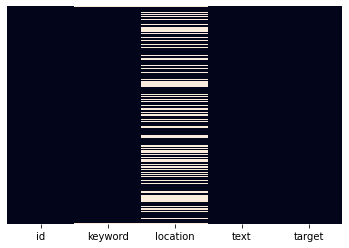

In [10]:
# 4.1.1 Missing values
sns.heatmap(tweet.isnull(), annot = False, cbar = False, yticklabels= False);

In [11]:
tweet.isnull().mean() # More than 30% of location data is missing

id          0.000000
keyword     0.008013
location    0.332720
text        0.000000
target      0.000000
dtype: float64

#### 4.1.2 Duplicate entries
There are no overall duplicate entries (as tweet id is unique), but from our previous analysis, we know some of the tweet texts are duplicate.

In [12]:
# 4.1.2 Duplicate entries
tweet.duplicated().sum()

0

In [13]:
tweet[tweet.text.duplicated()]

,id,keyword,location,text,target
48,68,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http:/...,0
115,165,aftershock,US,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...,0
119,172,aftershock,Switzerland,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/TH...,0
164,238,airplane%20accident,NaN,Experts in France begin examining airplane deb...,1
624,898,bioterrorism,NaN,To fight bioterrorism sir.,0
630,907,bioterrorism,NaN,To fight bioterrorism sir.,1
634,916,bioterrorism,NaN,To fight bioterrorism sir.,0
1156,1665,bombing,Singapore,Japan on Thursday marks the 70th anniversary o...,1
1251,1807,buildings%20on%20fire,UK,#TweetLikeItsSeptember11th2001 Those two build...,1
1331,1922,burning%20buildings,"Mackay, QLD, Australia",Mmmmmm I'm burning.... I'm burning buildings I...,0


It is clear that some of the tweets have been mislabelled, for example tweet id 907 is inconsistent with 898 and 916. And there are other tweets such as id 2346, which is referring to collapse as in defeat in a sporting event, rather than a physical disaster. There are also many tweets that are hard to interpret without the original context (such as accompanying images and dates) such as id 1922. In all, some of these entries are rather "dirty" and in fact there's no guarantee that the "non-duplicate" entries are any cleaner. Based on these observations:
* I am going to fix the labels of the clearly mislabelled entries.
* Fortunately, some fellow Kagglers have identified the proper labels, as seen [here](https://www.kaggle.com/code/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert).
* We can manually fix these mislabelled tweets using the approach in the link above.

#### 4.2 Data Characteristic Exploration

In [14]:
dis = tweet[tweet['target']==1]
non_dis = tweet[tweet['target']==0]

#### 4.2.1 Distribution of characters and words in a tweet
It seems that real disaster and non-disaster tweets follow roughly the same distribution in terms of character and word counts. However it should be noted, that real disaster tweets seem to be on average slightly longer in characters.

In [15]:
print(f"Real Disaster average character length {tweet[tweet['target']==1]['text'].str.len().mean()} vs. Not Disaster average character length {tweet[tweet['target']==0]['text'].str.len().mean()}")

Real Disaster average character length 108.11342097217977 vs. Not Disaster average character length 95.70681713496084


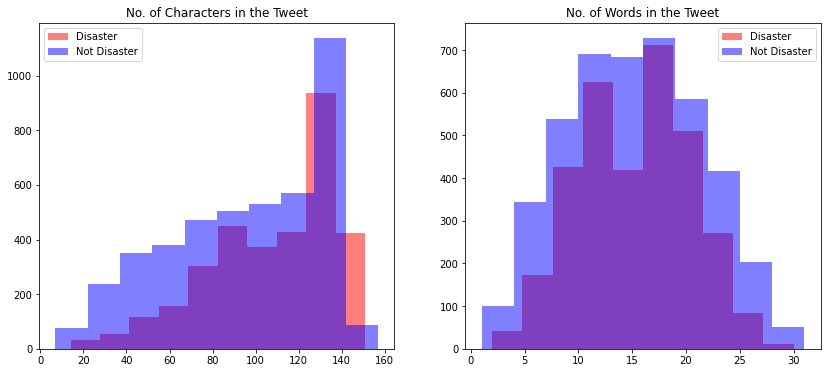

In [16]:
# 4.2.1 Distribution of characters and words
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (14, 6))

# characters
tweet1_char_len = dis['text'].str.len()
tweet0_char_len = non_dis['text'].str.len()
ax1.hist(tweet1_char_len, alpha = 0.5, label = 'Disaster', color = 'red')
ax1.hist(tweet0_char_len, alpha = 0.5, label = 'Not Disaster', color = 'blue')
ax1.legend()
ax1.title.set_text("No. of Characters in the Tweet")

# words
tweet1_word_len = dis['text'].str.split().apply(lambda x: len(x))
tweet0_word_len = non_dis['text'].str.split().apply(lambda x: len(x))
ax2.hist(tweet1_word_len, alpha = 0.5, label = 'Disaster', color = 'red')
ax2.hist(tweet0_word_len, alpha = 0.5, label = 'Not Disaster', color = 'blue')
ax2.legend()
ax2.title.set_text("No. of Words in the Tweet")

#### 4.2.2 Word Cloud of Disaster vs. Non Disaster
We can see that there are a lot of noisy words such as "https", "co", and special characters such as u^, that should be removed.

The Real Disasters data seem to contain more words associated with disasters such as bomber, flood and storm. While the Not Disasters data seem to contain more generic and stop words such as "will", "one", and "say".

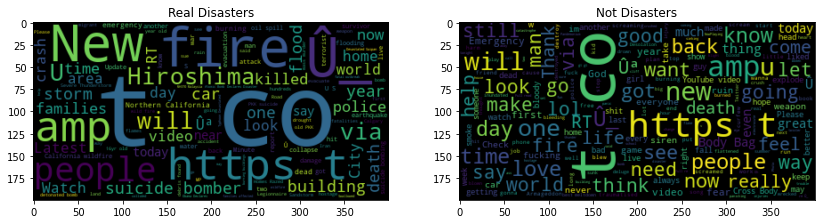

In [17]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (14, 6))
# disaster word cloud
txt = " ".join([twt for twt in dis.text]) # turn into a single string
wc = WordCloud().generate(txt)
ax1.imshow(wc, interpolation = 'bilinear')
ax1.title.set_text("Real Disasters")

# non disaster word cloud
txt = " ".join([twt for twt in non_dis.text]) # turn into a single string
wc = WordCloud().generate(txt)
ax2.imshow(wc, interpolation = 'bilinear')
ax2.title.set_text("Not Disasters");

#### 4.2.3 Distribution of Keyword and Location features

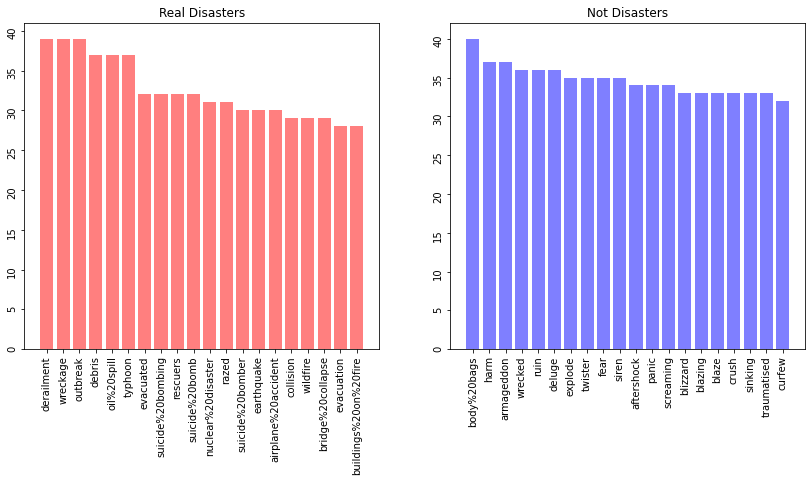

In [18]:
# Top 20 keywords
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (14, 6))

# disaster
ax1.bar(dis.keyword.value_counts()[:20].index, dis.keyword.value_counts()[:20].values, color = 'red', alpha = 0.5)
ax1.tick_params(labelrotation=90)
ax1.title.set_text("Real Disasters")

# not disaster
ax2.bar(non_dis.keyword.value_counts()[:20].index, non_dis.keyword.value_counts()[:20].values, color = 'blue', alpha = 0.5)
ax2.tick_params(labelrotation=90)
ax2.title.set_text("Not Disasters")

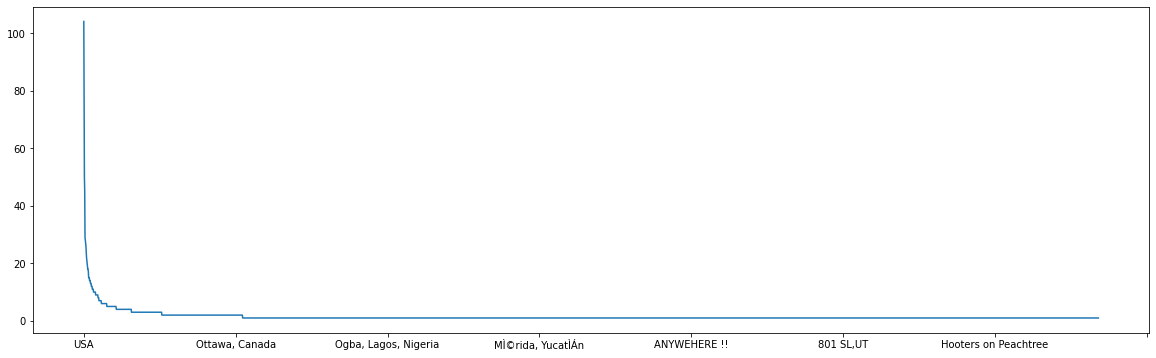

In [19]:
# Unique Locations
plt.figure(figsize = (20,6))
tweet.location.value_counts().plot(); 

Again, we can confirm that the location data is messy and contain a lot of nonsensical information such as "ANYWHERE !!"

#### 4.2.4 N-grams Analysis

In [20]:
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in stop_words]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

stop_words = set(stopwords.words("english"))

In [21]:
# Unigrams
disaster_unigrams = defaultdict(int)
nondisaster_unigrams = defaultdict(int)

for twt in dis['text']:
    for word in generate_ngrams(twt):
        disaster_unigrams[word] += 1
        
for twt in non_dis['text']:
    for word in generate_ngrams(twt):
        nondisaster_unigrams[word] += 1
        
df_disaster_unigrams = pd.DataFrame(sorted(disaster_unigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_unigrams = pd.DataFrame(sorted(nondisaster_unigrams.items(), key=lambda x: x[1])[::-1])

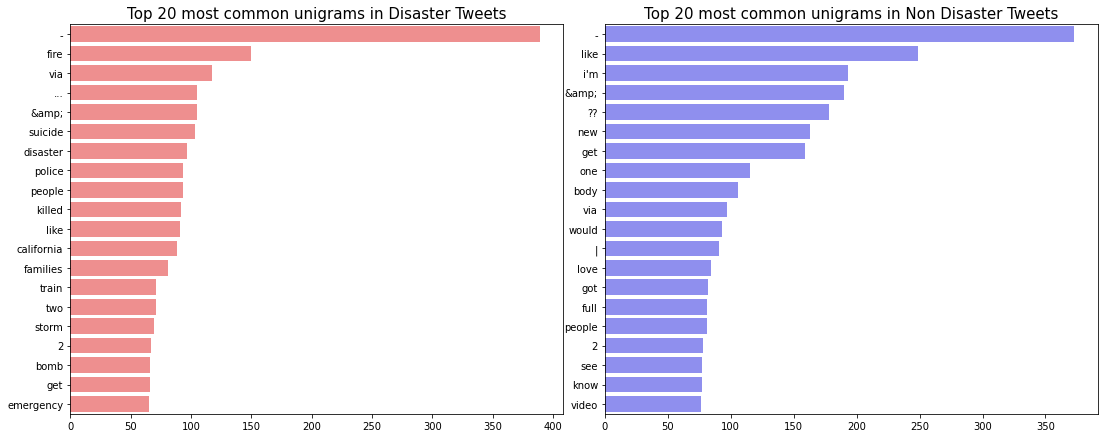

In [22]:
N = 20

fig, axes = plt.subplots(ncols=2, figsize=(15, 6))
plt.tight_layout()

sns.barplot(y=df_disaster_unigrams[0].values[:N], x=df_disaster_unigrams[1].values[:N], ax=axes[0], color='red', alpha = 0.5)
sns.barplot(y=df_nondisaster_unigrams[0].values[:N], x=df_nondisaster_unigrams[1].values[:N], ax=axes[1], color = 'blue', alpha = 0.5)

axes[0].set_title(f'Top {N} most common unigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common unigrams in Non Disaster Tweets', fontsize=15);

In [23]:
# Bigrams
disaster_bigrams = defaultdict(int)
nondisaster_bigrams = defaultdict(int)

for twt in dis['text']:
    for word in generate_ngrams(twt, n_gram = 2):
        disaster_bigrams[word] += 1
        
for twt in non_dis['text']:
    for word in generate_ngrams(twt, n_gram = 2):
        nondisaster_bigrams[word] += 1
        
df_disaster_bigrams = pd.DataFrame(sorted(disaster_bigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_bigrams = pd.DataFrame(sorted(nondisaster_bigrams.items(), key=lambda x: x[1])[::-1])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Glyph 137 (\x89) missing from current font.
  
/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 137 (\x89) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


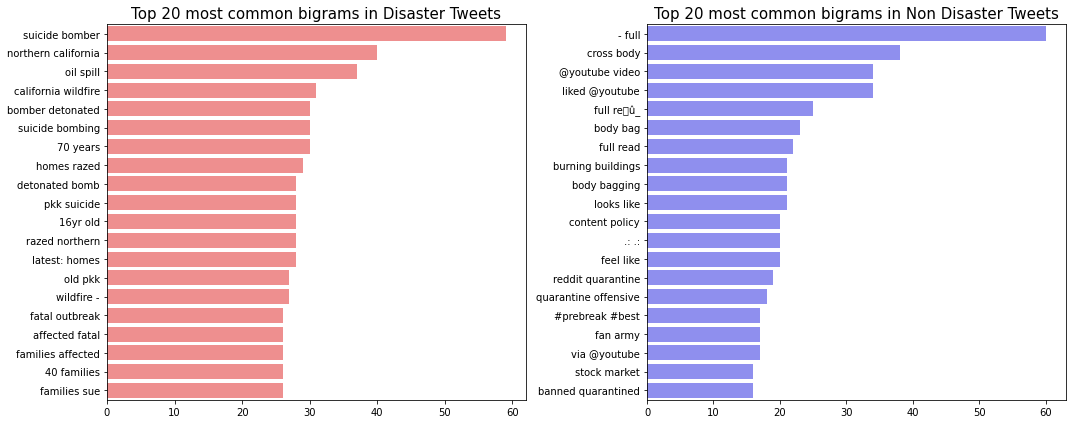

In [25]:
fig, axes = plt.subplots(1,2, figsize=(15, 6))

sns.barplot(y=df_disaster_bigrams[0].values[:N], x=df_disaster_bigrams[1].values[:N], ax=axes[0], color='red', alpha = 0.5)
sns.barplot(y=df_nondisaster_bigrams[0].values[:N], x=df_nondisaster_bigrams[1].values[:N], ax=axes[1], color = 'blue', alpha = 0.5)

axes[0].set_title(f'Top {N} most common bigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common bigrams in Non Disaster Tweets', fontsize=15)
plt.tight_layout();

In [26]:
# Trigrams
disaster_trigrams = defaultdict(int)
nondisaster_trigrams = defaultdict(int)

for twt in dis['text']:
    for word in generate_ngrams(twt, n_gram = 3):
        disaster_trigrams[word] += 1
        
for twt in non_dis['text']:
    for word in generate_ngrams(twt, n_gram = 3):
        nondisaster_trigrams[word] += 1
        
df_disaster_trigrams = pd.DataFrame(sorted(disaster_trigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_trigrams = pd.DataFrame(sorted(nondisaster_trigrams.items(), key=lambda x: x[1])[::-1])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Glyph 137 (\x89) missing from current font.
  
/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 137 (\x89) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


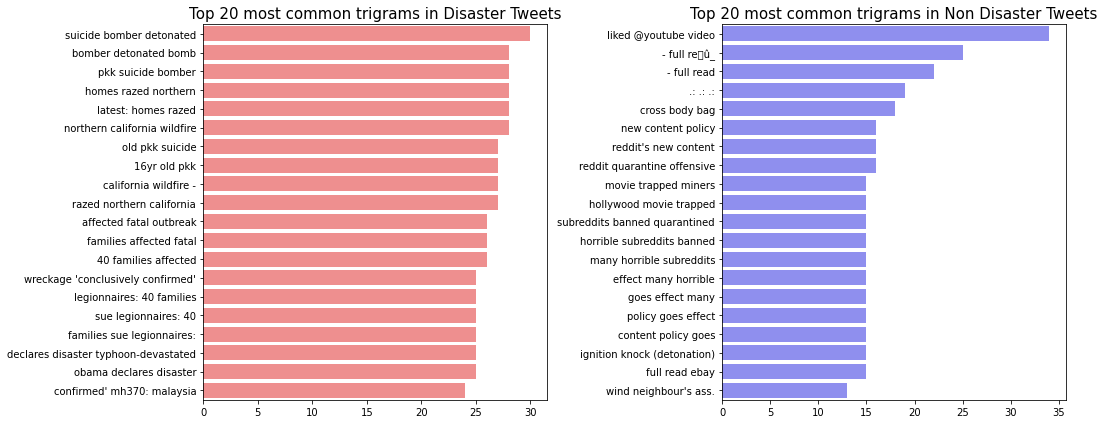

In [27]:
fig, axes = plt.subplots(1,2, figsize=(15, 6))

sns.barplot(y=df_disaster_trigrams[0].values[:N], x=df_disaster_trigrams[1].values[:N], ax=axes[0], color='red', alpha = 0.5)
sns.barplot(y=df_nondisaster_trigrams[0].values[:N], x=df_nondisaster_trigrams[1].values[:N], ax=axes[1], color = 'blue', alpha = 0.5)

axes[0].set_title(f'Top {N} most common trigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common trigrams in Non Disaster Tweets', fontsize=15)
plt.tight_layout();

-------------

## 5. Data Preparation and Cleaning

Twitter data is notoriously dirty and must be cleaned before feeding into our models. For example, tweets typically contain a lot of punctuations, html tags, emojis and urls, these often don't add additional meanings to the text but cause confusion for the algorithms.

There are many steps in preparing text data, the first step is often text cleaning, where we remove text components that are noisy and not useful for our model, such as punctuations, html tags and stop words. The next step is often word tokenization, where we turn raw text into numerical representations that can be understood and analyzed by computers. 

**Before we clean the texts themselves, let's first fix the tweets that were mislabelled as mentioned in the previous section**

In [5]:
tweet['target_relabeled'] = tweet['target'].copy() 

tweet.loc[tweet['text'] == 'like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit', 'target_relabeled'] = 0
tweet.loc[tweet['text'] == 'Hellfire is surrounded by desires so be careful and donÛªt let your desires control you! #Afterlife', 'target_relabeled'] = 0
tweet.loc[tweet['text'] == 'To fight bioterrorism sir.', 'target_relabeled'] = 0
tweet.loc[tweet['text'] == '.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4', 'target_relabeled'] = 1
tweet.loc[tweet['text'] == 'CLEARED:incident with injury:I-495  inner loop Exit 31 - MD 97/Georgia Ave Silver Spring', 'target_relabeled'] = 1
tweet.loc[tweet['text'] == '#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption', 'target_relabeled'] = 0
tweet.loc[tweet['text'] == 'In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!', 'target_relabeled'] = 0
tweet.loc[tweet['text'] == 'Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her\n \n#FARRAKHAN #QUOTE', 'target_relabeled'] = 1
tweet.loc[tweet['text'] == 'RT NotExplained: The only known image of infamous hijacker D.B. Cooper. http://t.co/JlzK2HdeTG', 'target_relabeled'] = 1
tweet.loc[tweet['text'] == "Mmmmmm I'm burning.... I'm burning buildings I'm building.... Oooooohhhh oooh ooh...", 'target_relabeled'] = 0
tweet.loc[tweet['text'] == "wowo--=== 12000 Nigerian refugees repatriated from Cameroon", 'target_relabeled'] = 0
tweet.loc[tweet['text'] == "He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam", 'target_relabeled'] = 0
tweet.loc[tweet['text'] == "Hellfire! We donÛªt even want to think about it or mention it so letÛªs not do anything that leads to it #islam!", 'target_relabeled'] = 0
tweet.loc[tweet['text'] == "The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'", 'target_relabeled'] = 0
tweet.loc[tweet['text'] == "Caution: breathing may be hazardous to your health.", 'target_relabeled'] = 1
tweet.loc[tweet['text'] == "I Pledge Allegiance To The P.O.P.E. And The Burning Buildings of Epic City. ??????", 'target_relabeled'] = 0
tweet.loc[tweet['text'] == "#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect", 'target_relabeled'] = 0
tweet.loc[tweet['text'] == "that horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time", 'target_relabeled'] = 0

### 5.1 Text Cleaning
We will apply the most commonly used cleaning steps here.

In [6]:
def text_clean(text):
  # Removing urls
  url = re.compile(r'https?://\S+|www\.\S+')
  text = url.sub(r'',text)

  # Removing html tags
  html = re.compile(r'<.*?>')
  text = html.sub(r'',text)

  # Removing emojis
  emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
  text = emoji_pattern.sub(r'', text)

  # Removing punctuations
  table= str.maketrans('','',string.punctuation)
  text = text.translate(table)

  text= str(text)
  training_tokens = text_to_word_sequence(text,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower = True, split = " ")
    
  # removing stop words
  stop_words = set(stopwords.words('english'))
  tokens_nostopwords = [word for word in training_tokens if not word in stop_words]
     
  # joining words into a sentence
  text_nostopwords = ' '.join(tokens_nostopwords)
        
  # removing numbers
  text_nonumbers = ''.join(word for word in text_nostopwords if word.isdigit()==0)
  
  return text_nonumbers

In [7]:
clean_tweet = tweet.copy()
clean_tweet['text'] = clean_tweet.text.apply(lambda x: text_clean(x))

In [52]:
tweet.text.head()

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
Name: text, dtype: object

In [53]:
clean_tweet.text.head()

0         deeds reason earthquake may allah forgive us
1                forest fire near la ronge sask canada
2    residents asked shelter place notified officer...
3     people receive wildfires evacuation orders ca...
4    got sent photo ruby alaska smoke wildfires pou...
Name: text, dtype: object

**As we can see below, our preprocessing has made the text data much cleaner.** We have a lot less html tags, and stop words.

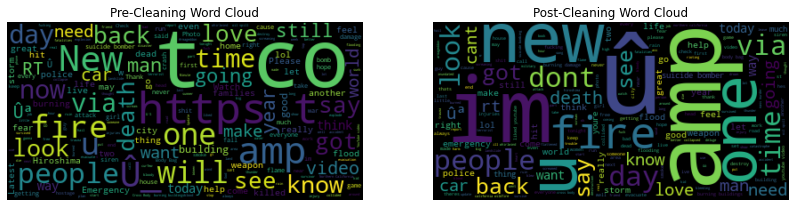

In [54]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (14, 6))
# pre-cleaning word cloud
txt = " ".join([twt for twt in tweet.text]) # turn into a single string
wc = WordCloud().generate(txt)
ax1.imshow(wc, interpolation = 'bilinear')
ax1.axis('off')
ax1.title.set_text("Pre-Cleaning Word Cloud")

# post-cleaning word cloud
txt = " ".join([twt for twt in clean_tweet.text]) # turn into a single string
wc = WordCloud().generate(txt)
ax2.imshow(wc, interpolation = 'bilinear')
ax2.title.set_text("Post-Cleaning Word Cloud")
ax2.axis('off');

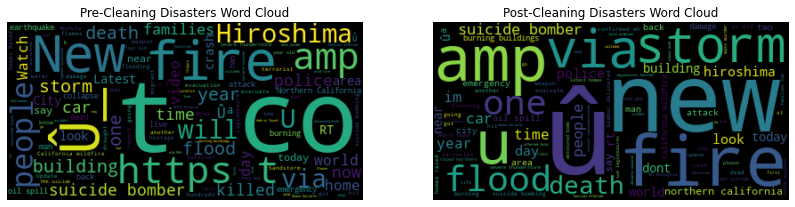

In [55]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (14, 6))
# pre-cleaning word cloud for Disasters
txt = " ".join([twt for twt in dis.text]) # turn into a single string
wc = WordCloud().generate(txt)
ax1.imshow(wc, interpolation = 'bilinear')
ax1.axis('off')
ax1.title.set_text("Pre-Cleaning Disasters Word Cloud")

# post-cleaning word cloud for Disasters
txt = " ".join([twt for twt in clean_tweet[clean_tweet.target ==1].text]) # turn into a single string
wc = WordCloud().generate(txt)
ax2.imshow(wc, interpolation = 'bilinear')
ax2.title.set_text("Post-Cleaning Disasters Word Cloud")
ax2.axis('off');

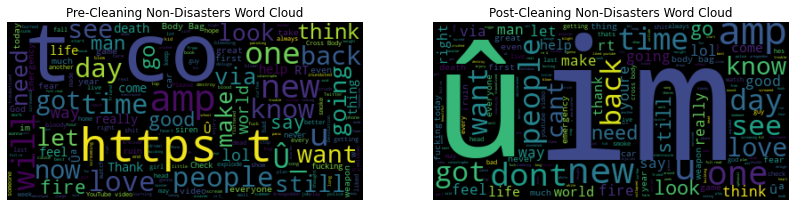

In [56]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (14, 6))
# pre-cleaning word cloud for Non-Disasters
txt = " ".join([twt for twt in non_dis.text]) # turn into a single string
wc = WordCloud().generate(txt)
ax1.imshow(wc, interpolation = 'bilinear')
ax1.axis('off')
ax1.title.set_text("Pre-Cleaning Non-Disasters Word Cloud")

# post-cleaning word cloud for Non-Disasters
txt = " ".join([twt for twt in clean_tweet[clean_tweet.target ==0].text]) # turn into a single string
wc = WordCloud().generate(txt)
ax2.imshow(wc, interpolation = 'bilinear')
ax2.title.set_text("Post-Cleaning Non-Disasters Word Cloud")
ax2.axis('off');

### 5.2 GloVe Vectorization
As mentioned previously, there are many ways to tokenize or represent raw text data. For example, we could use bag-of-words, or Tfidf (term frequency inverse document frequency). We could also use some pre-trained embeddings such as GloVe or FastText.

In this project we will use the popular GloVe approach. Note that the GloVe pretrained corpus model is available in a few varieties: 50D, 100D, 200D and 300D. We will use 300D here.

In [57]:
glove_embeddings = np.load('../input/pickled-glove840b300d-for-10sec-loading/glove.840B.300d.pkl', allow_pickle=True)

**Note that Kaggle allows you to use "Add data" to add useful tools/data such as the GloVe embeddings easily. If you were to replicate this you might need to download GloVe and import it locally.**

The following functions are from Gunes Evitan, a Kaggle Grandmaster. The original notebook can be found [here](https://www.kaggle.com/code/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert).

In [59]:
import operator

def build_vocab(X):
    
    tweets = X.apply(lambda s: s.split()).values      
    vocab = {}
    
    for tweet in tweets:
        for word in tweet:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1                
    return vocab


def check_embeddings_coverage(X, embeddings):
    
    vocab = build_vocab(X)    
    
    covered = {}
    oov = {}    
    n_covered = 0
    n_oov = 0
    
    for word in vocab:
        try:
            covered[word] = embeddings[word]
            n_covered += vocab[word]
        except:
            oov[word] = vocab[word]
            n_oov += vocab[word]
            
    vocab_coverage = len(covered) / len(vocab)
    text_coverage = (n_covered / (n_covered + n_oov))
    
    sorted_oov = sorted(oov.items(), key = operator.itemgetter(1))[::-1]
    return sorted_oov, vocab_coverage, text_coverage

train_glove_oov, train_glove_vocab_coverage, train_glove_text_coverage = check_embeddings_coverage(tweet['text'], glove_embeddings)
test_glove_oov, test_glove_vocab_coverage, test_glove_text_coverage = check_embeddings_coverage(test['text'], glove_embeddings)
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(train_glove_vocab_coverage, train_glove_text_coverage))
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Test Set'.format(test_glove_vocab_coverage, test_glove_text_coverage))

GloVe Embeddings cover 52.06% of vocabulary and 82.68% of text in Training Set
GloVe Embeddings cover 57.21% of vocabulary and 81.85% of text in Test Set


In [60]:
clean_test = test.copy()
clean_test['text'] = clean_test.text.apply(lambda x: text_clean(x))

train_glove_oov, train_glove_vocab_coverage, train_glove_text_coverage = check_embeddings_coverage(clean_tweet['text'], glove_embeddings)
test_glove_oov, test_glove_vocab_coverage, test_glove_text_coverage = check_embeddings_coverage(clean_test['text'], glove_embeddings)
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Cleaned Training Set'.format(train_glove_vocab_coverage, train_glove_text_coverage))
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Cleaned Test Set'.format(test_glove_vocab_coverage, test_glove_text_coverage))

GloVe Embeddings cover 72.09% of vocabulary and 91.31% of text in Cleaned Training Set
GloVe Embeddings cover 76.67% of vocabulary and 90.78% of text in Cleaned Test Set


We can verify the benefits of performing text cleaning on our train and test sets! Before our text cleaning process, the GloVe Embeddings only covered about half of the vocabs and 80% of text in training and text sets. But after text cleaning, Embedding covered increased from 50% to more than 70%, and text coverage increased from 80% to 90%!

After cleaning the tweets, glove_embeddings can be deleted and garbage collected because they consume too much memory.

In [62]:
import gc
del glove_embeddings, train_glove_oov, test_glove_oov
gc.collect()

66682

In [10]:
clean_tweet.head()

,id,keyword,location,text,target,target_relabeled
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1,1
2,5,NaN,NaN,residents asked shelter place notified officer...,1,1
3,6,NaN,NaN,people receive wildfires evacuation orders ca...,1,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1,1


In [25]:
texts = clean_tweet['text']
target = clean_tweet['target_relabeled']

To actually use the GloVe embeddings, we need to perform a number of steps:
1. Tokenization: We need to first convert strings of text into collections of words or tokens. The benefit of tokenization is that it makes it easier to turn text format into numerical representation that can be processed by computers.
2. Padding: Neural networks require inputs of the same shape and size, however, our texts clearly have different length, therefore, we need to pad them (add values to them) that give them the same length. We can also define maximum number of words for each sentence, if a sentence is longer then we can drop some words. 
3. GloVe method: We can derive semantic relationships between words in a text from the co-occurence matrix. We can obtain a vector representation of these words using an unsupervised ML algorithm called GloVe, which stands for Global Vectors for Word Representation. GloVe focuses on word co-occurences over the entire corpus, its embeddings relate to the probabilities of two words appearing together.

**Tokenization and vocab length**

In [26]:
# Calculate the length of our vocabulary
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(texts)

vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

17117

**Padding**

We can see from the output below, that some of the texts have been padded with 0s.

In [27]:
def embed(corpus): 
    return word_tokenizer.texts_to_sequences(corpus)

longest_train = max(texts, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))

train_padded_sentences = pad_sequences(
    embed(texts), 
    length_long_sentence, 
    padding='post'
)

train_padded_sentences

array([[4263,  711,  147, ...,    0,    0,    0],
       [  96,    4,  130, ...,    0,    0,    0],
       [1549, 1428, 1934, ...,    0,    0,    0],
       ...,
       [ 625, 3953,  476, ...,    0,    0,    0],
       [  16,  978, 2956, ...,    0,    0,    0],
       [ 113,  109,  422, ...,    0,    0,    0]], dtype=int32)

In [28]:
embeddings_dictionary = dict()

# Load GloVe 300D embeddings
with open('../input/glove6b300dtxt/glove.6B.300d.txt') as fp:
    for line in fp.readlines():
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary [word] = vector_dimensions

In [29]:
# Now we will load embedding vectors of those words that appear in the
# Glove dictionary. Others will be initialized to 0.
embedding_dim = 300

embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
        
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.13443001, -0.016333  ,  0.091076  , ..., -0.27469   ,
        -0.059464  ,  0.49494001],
       [ 0.53152001,  0.0072166 ,  0.076086  , ..., -0.060627  ,
         0.12098   ,  0.50568998],
       ...,
       [ 0.41097   ,  0.029318  ,  0.088117  , ...,  0.21619   ,
         0.52669001,  0.32398   ],
       [-0.54781997,  0.21716   ,  0.035452  , ..., -0.45647001,
         0.12208   , -0.54895997],
       [-0.39368999,  0.68974   ,  0.0070582 , ..., -0.22226   ,
         0.44356999, -0.63275999]])

In [22]:
# import pickle
# embedding_matrix_file = "embedding_matrix.pickle"
# with open(embedding_matrix_file,'wb') as f:
#     pickle.dump("embedding_matrix_file", f)

-------------

## 6. Modelling

### 6.1 Baseline Model - Logistic Regression
It is always important to first establish a baseline model as a basis for model comparison and iteration. For NLP classification tasks, some simple but popular choices include Naive Bayes and Logistic Regression. Here we will use Logistic Regression model as our simple baseline. The Logistic Regression algorithm has the advantages of simplicity, explanability, fast to train and it can even be thought of as a **single-layer neural network with a sigmoid activation function**. Given these advantages, it makes sense to use Logistic Regression as our baseline model.

In [9]:
# First creating our training and validation sets
X = clean_tweet['text']
y = clean_tweet['target_relabeled']

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 42, test_size = 0.2)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(6090,) (6090,)
(1523,) (1523,)


In [12]:
# preprocessing and training
pipe = Pipeline([('tfid', TfidfVectorizer()),  #combines countvectorizer and tfidf transformer in a single step
                 ('model', LogisticRegression())])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_val)

print(f"Logistic Regression achieves a baseline F1 score of {f1_score(y_val, y_pred)}")

Logistic Regression achieves a baseline F1 score of 0.7438715131022823


In [15]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.89      0.84       874
           1       0.82      0.68      0.74       649

    accuracy                           0.80      1523
   macro avg       0.81      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523



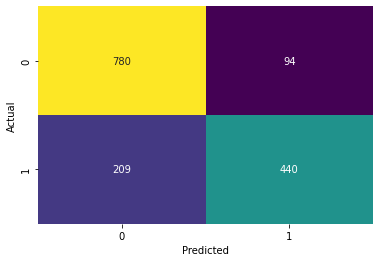

In [23]:
sns.heatmap(confusion_matrix(y_val, y_pred), cmap = 'viridis', annot = True, fmt = 'd', cbar = False)
plt.xlabel('Predicted')
plt.ylabel('Actual');

Our logistic regression baseline achieves an F1 score of 0.74. From the confusion matrix and the classification report, we can see that our model does poorly when it comes to identifying some of the Actual disasters and mislabelling those tweets as non-disasters. We can see it from the high False Negatives in the confusion matrix, and the low recall score (when y = 1) in the classification report.

Remember that the raw proportion of disaster tweets in the data was 43%, and our simple logistic regression's accuracy of 80% still marks a huge improvemenet over random guess on the raw data.

### 6.2 RNN Model - LSTM baseline
Now we will move onto our second model, the RNN LSTM (long short term memory) model. We will first start with a simple RNN-LSTM structure and use it as our baseline RNN model.

In [30]:
# First creating the training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    train_padded_sentences, 
    target, 
    random_state = 42,
    test_size=0.20
)

So for our model, we will use a simple RNN architecture. The embedding used is based on our GloVe embeddings from before. We will then add a spatial dropout layer, which is for the same purpose as the regular dropout layer, but is more useful when frames in feature maps are correlated, which is often the case in early layers. We then at the LSTM layer with some dropout for regularization. And finally add a fully-connected/dense layer, and use sigmoid activation function since we are doing binary classification. As we can see, this is a very simple, very basic model.

In [33]:
model=Sequential()

embedding=Embedding(input_dim=embedding_matrix.shape[0], 
        output_dim=embedding_matrix.shape[1], 
        weights = [embedding_matrix], 
        input_length=length_long_sentence)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 23, 300)           5135100   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 23, 300)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 5,228,605
Trainable params: 5,228,605
Non-trainable params: 0
_________________________________________________________________


In [38]:
# Since our metric is F1 score and since Keras doesn't have an inbuilt F1, we will write a customized version and use it in the compiler
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [39]:
# Using the popular Adam method, with a learning rate of 1e-3~1e-5 are genenrally good starting points

model.compile(loss = keras.losses.binary_crossentropy,
              optimizer=tf.keras.optimizers.Adam(1e-5),
              metrics=get_f1)

In [40]:
# simple model
history = model.fit(
    X_train,
    y_train,
    batch_size = 10, 
    epochs = 20,
    validation_data=(X_val, y_val),
)

Epoch 1/20
609/609 [==============================] - 31s 47ms/step - loss: 0.6878 - get_f1: 0.1526 - val_loss: 0.6821 - val_get_f1: 0.0527
Epoch 2/20
609/609 [==============================] - 28s 46ms/step - loss: 0.6722 - get_f1: 0.0882 - val_loss: 0.6515 - val_get_f1: 0.2898
Epoch 3/20
609/609 [==============================] - 28s 45ms/step - loss: 0.6058 - get_f1: 0.4925 - val_loss: 0.5251 - val_get_f1: 0.6830
Epoch 4/20
609/609 [==============================] - 28s 45ms/step - loss: 0.5132 - get_f1: 0.6786 - val_loss: 0.4736 - val_get_f1: 0.7177
Epoch 5/20
609/609 [==============================] - 28s 46ms/step - loss: 0.4834 - get_f1: 0.7010 - val_loss: 0.4616 - val_get_f1: 0.7229
Epoch 6/20
609/609 [==============================] - 28s 46ms/step - loss: 0.4711 - get_f1: 0.7064 - val_loss: 0.4552 - val_get_f1: 0.7317
Epoch 7/20
609/609 [==============================] - 28s 47ms/step - loss: 0.4623 - get_f1: 0.7146 - val_loss: 0.4489 - val_get_f1: 0.7291
Epoch 8/20
609/609 [

In [41]:
# defining a helper function for plotting results
def show_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["get_f1"], label="Train F1")
    ax[1].plot(history.epoch, history.history["val_get_f1"], label="Validation F1")
    ax[0].legend()
    ax[1].legend()

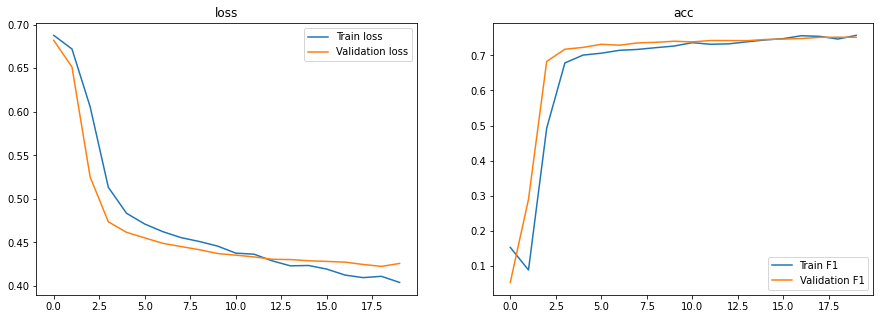

In [42]:
show_history(history)

In [44]:
y_pred = (model.predict(X_val) > 0.5).astype("int32")
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.87      0.85       874
           1       0.81      0.74      0.78       649

    accuracy                           0.82      1523
   macro avg       0.82      0.81      0.81      1523
weighted avg       0.82      0.82      0.82      1523



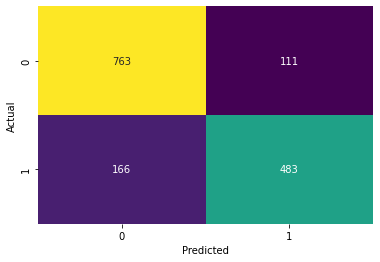

In [45]:
sns.heatmap(confusion_matrix(y_val, y_pred), cmap = 'viridis', annot = True, fmt = 'd', cbar = False)
plt.xlabel('Predicted')
plt.ylabel('Actual');

We can make a number of observations:
* The RNN-LSTM model slightly outperforms our Logistic Regression, with an accuracy of 82% vs 80%, and an F1 score of 0.78 vs. 0.74.
* The training F1 and validation F1 scores plateaued after around the 13th Epoch, they are still increasing but at a very slow rate. 

### 6.3 RNN Model - LSTM Improved
In the baseline RNN-LSTM model, we used a standard or unidirectional LSTM. It is often argued that Bidirectional LSTMs or BiLSTMs tend to perform better. [For example](
https://www.baeldung.com/cs/bidirectional-vs-unidirectional-lstm), BiLSTM is capable of capturing information from both directions of information flow (forward and backward), and therefore has the potential to establish greater context when it comes to NLP. For this reason BiLSTM tend to perform better than LSTM in many cases, but it is also much slower and requires more training time.

The model below is inspired by this[ post](https://www.kaggle.com/mariapushkareva/nlp-disaster-tweets-with-glove-and-lstm/data).

In [117]:
model=Sequential()

embedding=Embedding(input_dim=embedding_matrix.shape[0], 
        output_dim=embedding_matrix.shape[1], 
        weights = [embedding_matrix], 
        input_length=length_long_sentence)

model.add(embedding)

model.add(Bidirectional(LSTM(
        length_long_sentence, 
        return_sequences = True, 
        recurrent_dropout=0.2
    )))

model.add(GlobalMaxPool1D())
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(length_long_sentence, activation = "relu"))

model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 23, 300)           5135100   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 23, 46)            59616     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 46)                0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 46)                184       
_________________________________________________________________
dropout_4 (Dropout)          (None, 46)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 23)                1081      
_________________________________________________________________
dense_12 (Dense)             (None, 1)               

In [65]:
model.compile(loss = keras.losses.binary_crossentropy,
              optimizer=tf.keras.optimizers.Adam(1e-5),
              metrics=get_f1)

In [77]:
# improved model - bidirectional lstm
history = model.fit(
    X_train,
    y_train,
    batch_size = 16, 
    epochs = 20,
    validation_data=(X_val, y_val),
)

Epoch 1/20
381/381 [==============================] - 68s 178ms/step - loss: 0.2041 - get_f1: 0.8977 - val_loss: 0.4951 - val_get_f1: 0.7487
Epoch 2/20
381/381 [==============================] - 68s 178ms/step - loss: 0.2006 - get_f1: 0.8979 - val_loss: 0.5135 - val_get_f1: 0.7537
Epoch 3/20
381/381 [==============================] - 69s 181ms/step - loss: 0.1913 - get_f1: 0.9095 - val_loss: 0.5230 - val_get_f1: 0.7380
Epoch 4/20
381/381 [==============================] - 69s 181ms/step - loss: 0.1574 - get_f1: 0.9287 - val_loss: 0.5405 - val_get_f1: 0.7425
Epoch 5/20
381/381 [==============================] - 68s 179ms/step - loss: 0.1503 - get_f1: 0.9280 - val_loss: 0.5677 - val_get_f1: 0.7483
Epoch 6/20
381/381 [==============================] - 68s 179ms/step - loss: 0.1396 - get_f1: 0.9318 - val_loss: 0.5957 - val_get_f1: 0.7517
Epoch 7/20
381/381 [==============================] - 68s 179ms/step - loss: 0.1339 - get_f1: 0.9375 - val_loss: 0.6677 - val_get_f1: 0.7378
Epoch 8/20
38

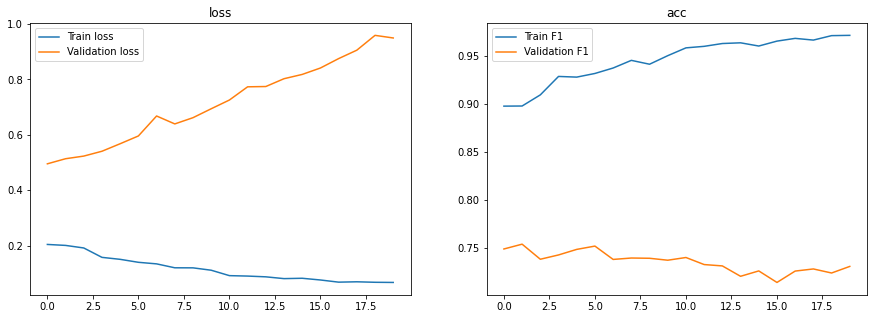

In [78]:
show_history(history)

In [79]:
y_pred = (model.predict(X_val) > 0.5).astype("int32")
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.80      0.81       874
           1       0.74      0.75      0.74       649

    accuracy                           0.78      1523
   macro avg       0.77      0.78      0.77      1523
weighted avg       0.78      0.78      0.78      1523



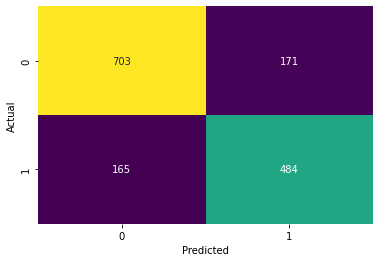

In [80]:
sns.heatmap(confusion_matrix(y_val, y_pred), cmap = 'viridis', annot = True, fmt = 'd', cbar = False)
plt.xlabel('Predicted')
plt.ylabel('Actual');

We can see signs of overfitting in our model, especially with the validation F1 decreasing while the training F1 increasing with more epochs. We can also see a worsening in performance in both the accuracy and F1 scores in the BiLSTM vs. previous models. This might indicate that our data is perhaps too "simple" for a complex model.

------------

## 7. Hyperparameter Tuning and Further Model Improvement
There are many ways to do hyperparameter tuning:

- First, we could use loop over different combination of hyperparameter values in model fitting, much like doing a grid-search.
- Another popular approach is to automatically search for the optimal hyperparameters using Bayesian Optimization or Random Search. This can be done with Python packages such as Keras Tuner.
- However due to the very limited computing resources available, here we will take a more manual process and try fewer hyparameter combinations so that the notebook won't constantly crash/restart.
- If we had a local GPU or more abundament cloud resources, we would choose a more sophisticated tuning method.

### 7.1 Learning Rate
Learning rate is one of the most important hyperparameters, we don't want a learning rate that is too high wherein we are unable to converge to global minima, and not too low either such that we are extremely slow to converge. We usually try powers of 10, e.g. 0.0001, 0.001, 0.01 etc. But we can of course try any learning rate and see what works well. For our model, let's increase our learning rate from 1e-5 to 1e-4.

In [81]:
# same model as previously but faster learning rate
model.compile(loss = keras.losses.binary_crossentropy,
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=get_f1)

In [82]:
# improved model - bidirectional lstm
history = model.fit(
    X_train,
    y_train,
    batch_size = 16, 
    epochs = 20,
    validation_data=(X_val, y_val),
)

Epoch 1/20
381/381 [==============================] - 72s 178ms/step - loss: 0.0602 - get_f1: 0.9734 - val_loss: 0.9602 - val_get_f1: 0.7230
Epoch 2/20
381/381 [==============================] - 68s 179ms/step - loss: 0.0554 - get_f1: 0.9749 - val_loss: 0.9945 - val_get_f1: 0.7131
Epoch 3/20
381/381 [==============================] - 69s 182ms/step - loss: 0.0595 - get_f1: 0.9747 - val_loss: 1.0927 - val_get_f1: 0.7209
Epoch 4/20
381/381 [==============================] - 68s 179ms/step - loss: 0.0540 - get_f1: 0.9749 - val_loss: 0.9941 - val_get_f1: 0.7216
Epoch 5/20
381/381 [==============================] - 68s 178ms/step - loss: 0.0484 - get_f1: 0.9799 - val_loss: 1.0759 - val_get_f1: 0.7204
Epoch 6/20
381/381 [==============================] - 68s 178ms/step - loss: 0.0504 - get_f1: 0.9800 - val_loss: 1.0722 - val_get_f1: 0.7196
Epoch 7/20
381/381 [==============================] - 67s 177ms/step - loss: 0.0465 - get_f1: 0.9805 - val_loss: 1.0470 - val_get_f1: 0.7211
Epoch 8/20
38

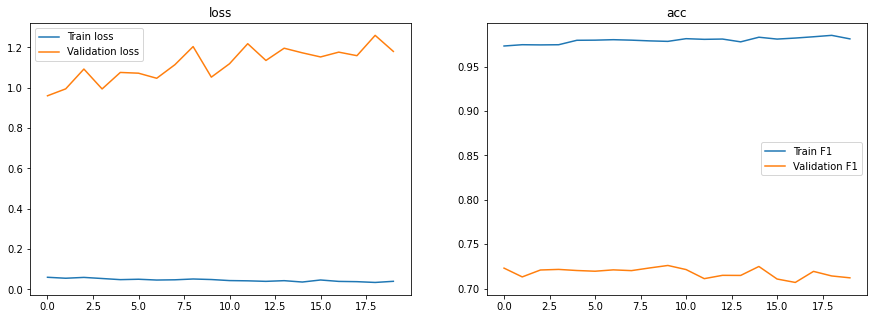

In [83]:
show_history(history)

In [84]:
y_pred = (model.predict(X_val) > 0.5).astype("int32")
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.85      0.82       874
           1       0.77      0.69      0.73       649

    accuracy                           0.78      1523
   macro avg       0.78      0.77      0.77      1523
weighted avg       0.78      0.78      0.78      1523



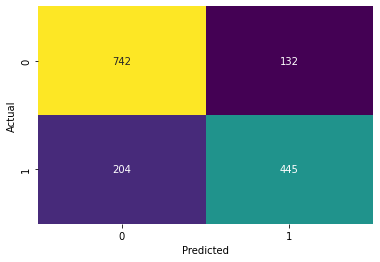

In [85]:
sns.heatmap(confusion_matrix(y_val, y_pred), cmap = 'viridis', annot = True, fmt = 'd', cbar = False)
plt.xlabel('Predicted')
plt.ylabel('Actual');

Again, we see a decrease in performance in both the Accuracy and F1 score. This was actually expected, and provides further evidence that our BiLSTM model is overfitting. A faster learning rate usually means faster convergence, but here it is likely to have overshot.

### 7.2 Dynamic learning rate

It is sometimes useful to choose a dynamic learning rate, that starts off high, then gradually slows down as training proceeds. We will use the ReduceLROnPlateau object to help us complete this task.

In [94]:
model.compile(loss = keras.losses.binary_crossentropy,
              optimizer=tf.keras.optimizers.Adam(1e-2),
              metrics=get_f1)

reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss', 
    factor = 0.2, 
    verbose = 1, 
    patience = 5,                        
    min_lr = 0.0001
)

history = model.fit(
    X_train, 
    y_train, 
    epochs = 20,
    batch_size = 16,
    validation_data = (X_val, y_val),
    verbose = 1,
    callbacks = [reduce_lr]
)

Epoch 1/20
381/381 [==============================] - 99s 180ms/step - loss: 0.3675 - get_f1: 0.8127 - val_loss: 0.5062 - val_get_f1: 0.7290
Epoch 2/20
381/381 [==============================] - 69s 182ms/step - loss: 0.2322 - get_f1: 0.8952 - val_loss: 0.5179 - val_get_f1: 0.7440
Epoch 3/20
381/381 [==============================] - 69s 181ms/step - loss: 0.1497 - get_f1: 0.9314 - val_loss: 0.6454 - val_get_f1: 0.7297
Epoch 4/20
381/381 [==============================] - 69s 180ms/step - loss: 0.1300 - get_f1: 0.9432 - val_loss: 0.7431 - val_get_f1: 0.7130
Epoch 5/20
381/381 [==============================] - 68s 180ms/step - loss: 0.1179 - get_f1: 0.9528 - val_loss: 0.8139 - val_get_f1: 0.6895
Epoch 6/20
381/381 [==============================] - 68s 179ms/step - loss: 0.1081 - get_f1: 0.9518 - val_loss: 0.8842 - val_get_f1: 0.6950

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0019999999552965165.
Epoch 7/20
381/381 [==============================] - 69s 181ms/step - lo

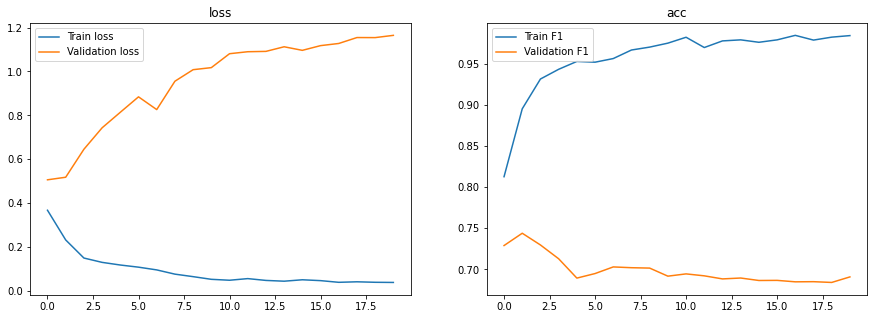

In [95]:
show_history(history)

In [96]:
y_pred = (model.predict(X_val) > 0.5).astype("int32")
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.84      0.81       874
           1       0.76      0.67      0.71       649

    accuracy                           0.77      1523
   macro avg       0.77      0.75      0.76      1523
weighted avg       0.77      0.77      0.77      1523



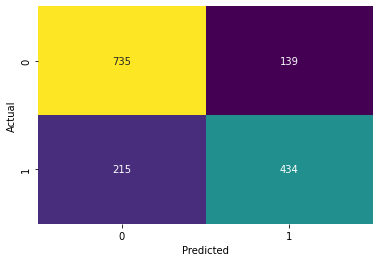

In [97]:
sns.heatmap(confusion_matrix(y_val, y_pred), cmap = 'viridis', annot = True, fmt = 'd', cbar = False)
plt.xlabel('Predicted')
plt.ylabel('Actual');

We may have set the initial learning rate too high.

### 7.3 Hidden Layers
Hidden layers are the layers between the input and output layers. There is no hard and fast rule on how many hidden layers one should use, and it is often chosen through a trial and error approach. More hidden layers give the model better chance to learn more complex features, however it is NOT true that more complex model are always better models. For simple problems/datasets, complex models often significantly overfit and fail.

Here we are adding additional layers in our RNN, and I'd like to verify that this added complexity won't necessarily improve our model's performance.

In [98]:
model=Sequential()

embedding=Embedding(input_dim=embedding_matrix.shape[0], 
        output_dim=embedding_matrix.shape[1], 
        weights = [embedding_matrix], 
        input_length=length_long_sentence)

model.add(embedding)

model.add(Bidirectional(LSTM(
        length_long_sentence, 
        return_sequences = True, 
        recurrent_dropout=0.2
    )))

model.add(GlobalMaxPool1D())
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(length_long_sentence, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(length_long_sentence, activation = "relu"))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 23, 300)           5135100   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 23, 46)            59616     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 46)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 46)                184       
_________________________________________________________________
dropout_1 (Dropout)          (None, 46)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 23)                1081      
_________________________________________________________________
dropout_2 (Dropout)          (None, 23)               

In [99]:
model.compile(loss = keras.losses.binary_crossentropy,
              optimizer=tf.keras.optimizers.Adam(1e-2),
              metrics=get_f1)

history = model.fit(
    X_train, 
    y_train, 
    epochs = 20,
    batch_size = 16,
    validation_data = (X_val, y_val),
    verbose = 1,
    callbacks = [reduce_lr]
)

Epoch 1/20
381/381 [==============================] - 72s 181ms/step - loss: 0.6044 - get_f1: 0.5908 - val_loss: 0.4672 - val_get_f1: 0.6626
Epoch 2/20
381/381 [==============================] - 69s 181ms/step - loss: 0.4701 - get_f1: 0.7451 - val_loss: 0.4464 - val_get_f1: 0.7311
Epoch 3/20
381/381 [==============================] - 69s 182ms/step - loss: 0.3751 - get_f1: 0.8245 - val_loss: 0.4912 - val_get_f1: 0.7544
Epoch 4/20
381/381 [==============================] - 68s 179ms/step - loss: 0.2870 - get_f1: 0.8792 - val_loss: 0.4559 - val_get_f1: 0.7226
Epoch 5/20
381/381 [==============================] - 68s 178ms/step - loss: 0.2419 - get_f1: 0.9012 - val_loss: 0.5843 - val_get_f1: 0.7170
Epoch 6/20
381/381 [==============================] - 68s 179ms/step - loss: 0.2261 - get_f1: 0.9152 - val_loss: 0.7494 - val_get_f1: 0.7113
Epoch 7/20
381/381 [==============================] - 69s 181ms/step - loss: 0.1889 - get_f1: 0.9254 - val_loss: 0.7440 - val_get_f1: 0.7225

Epoch 00007:

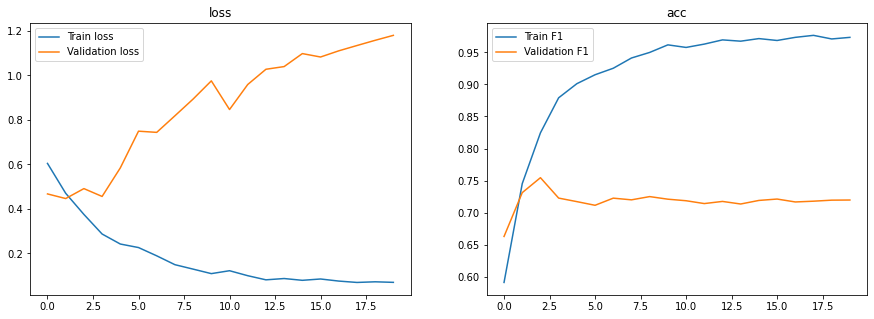

In [100]:
show_history(history)

In [101]:
y_pred = (model.predict(X_val) > 0.5).astype("int32")
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.86      0.82       874
           1       0.79      0.69      0.74       649

    accuracy                           0.79      1523
   macro avg       0.79      0.78      0.78      1523
weighted avg       0.79      0.79      0.79      1523



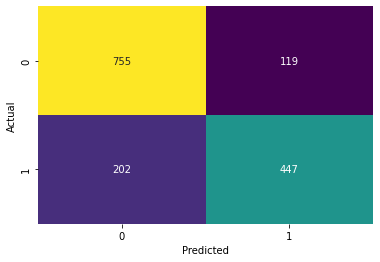

In [102]:
sns.heatmap(confusion_matrix(y_val, y_pred), cmap = 'viridis', annot = True, fmt = 'd', cbar = False)
plt.xlabel('Predicted')
plt.ylabel('Actual');

While this version of our model has achieved an improved performance compared with previous versions of BiLSTM, it still falls short of the simpler models. 

---------

## 8. Discussion and Summary of Results

### 8.1 Summary of Results

### 8.2 Summary of Modelling and Tuning Choices

-------

## 9. Conclusion

---

**Submission**

In [48]:
clean_test = test.copy()
clean_test['text'] = clean_test.text.apply(lambda x: text_clean(x))
clean_test.head()

,id,keyword,location,text
0,0,NaN,NaN,happened terrible car crash
1,2,NaN,NaN,heard earthquake different cities stay safe ev...
2,3,NaN,NaN,forest fire spot pond geese fleeing across str...
3,9,NaN,NaN,apocalypse lighting spokane wildfires
4,11,NaN,NaN,typhoon soudelor kills china taiwan


In [51]:
test = pad_sequences(
    embed(clean_test['text']), 
    length_long_sentence, 
    padding='post'
)

In [122]:
y_pred = model.predict(test)

model_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
model_submission['target'] = np.round(y_pred).astype('int')
model_submission.to_csv('model_submission.csv', index=False)
model_submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [123]:
from IPython.display import FileLink
FileLink('model_submission.csv')

/kaggle/working/model_submission.csv